# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Tensorflow Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Data Augmentation & Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Data Augmentation을 적용하세요.(Image Generator)
            * Transfer Learning(VGG16)
* 성능 가이드
    * Accuracy : 0.34~0.74

* 큰 흐름을 정리해보자. 크게 2가지를 하라는 것 같다.

  * 1. 모델링1용 전처리 -> 모델링1(Conv2D, Maxpooling2D, Flatten, Dense를 이용하자.)

  * 2. 모델링2용 전처리 -> 모델링2(Image DataAugmentation, Transfer Learning)


  * 일단 1번을 완성하고 2번을 생각하보자. 그니까 1번만 생각하자.<br> 1번 완성할지 모를판에 2번까지 생각하면 머리가 아프다.

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

### (1) 경로 설정

In [1]:
# 구글 코랩 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 라이브러리 불러오기

In [2]:
import zipfile, os, random, shutil, glob, yaml, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### (3) 데이터 불러오기

#### 1) 데이터 압축 해제

In [3]:
path = '/content/drive/MyDrive/미니프로젝트6차part2'

In [4]:
# file1 = 'Car_Images.zip'
# path + file1

In [5]:
# 압축 해제

# data = zipfile.ZipFile(path+file1)

# try :
#     print('압축을 해제합니다.')
#     data.extractall(path)
#     print('압축 해제가 완료되었습니다.')
# except :
#     pass
#     print('압축이 이미 해제되었거나 이미 폴더가 존재합니다.')

#### 2) 데이터 조회

In [6]:
# 폴더별 이미지 데이터 갯수 확인

print(f"정상 차량 이미지 데이터는 {len(glob.glob(path+'/normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(path+'/abnormal/*'))}장 입니다.")

정상 차량 이미지 데이터는 302장 입니다.
파손 차량 이미지 데이터는 303장 입니다.


* 정상 차량 이미지와 파손 차량 이미지 데이터가 각각 302장, 303장이여서 데이터 불균형은 없구나 라는 생각이 들었었습니다.

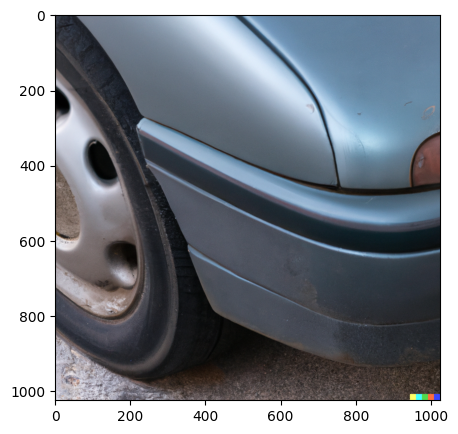

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [7]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
rand_n = random.randint( 0, len(glob.glob(path+'/normal/*'))-1)

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'/normal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

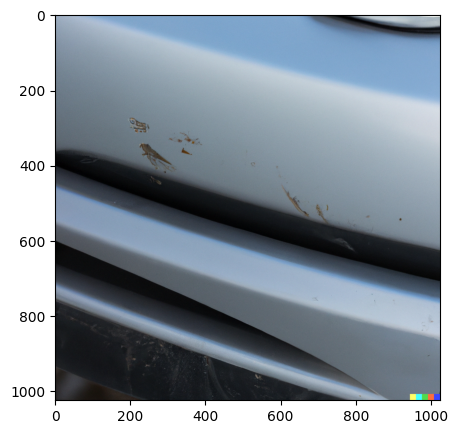

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [8]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인

rand_n = random.randint( 0, len(glob.glob(path+'/abnormal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'/abnormal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

## 2.데이터 전처리

### (1) 모델링 I용 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

#### 1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

* 개인적으로 normal를 1, abnormal을 0으로 지정했다면 괜찮을듯싶다.
왜냐하면 0은 부정적 이미지(False), 1은 긍정적 이미지(True) 느낌이기 떄문이다.

* 생까고, normal을 1로 주고, abnormal를 0을 주면 되는데 걍 가이드대로 하겠습니다.

In [9]:
normal_OR_abnormal = [1] * 303 + [0] * 302

In [10]:
normal_OR_abnormal

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


#### 2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [11]:
import os

In [12]:
abnormal_images = os.listdir(f'{path}/abnormal') # 파손 차량 이미지들
normal_images = os.listdir(f'{path}/normal') # 정상 차량 이미지들

# 가져온 이미지 파일 리스트 출력
print(abnormal_images)  # abnormal 폴더 내의 파일 리스트 출력
print(normal_images)    # normal 폴더 내의 파일 리스트 출력

['DALLíñE 2023-03-10 18.51.24 - scratched car.png', 'DALLíñE 2023-03-10 18.53.58 - slightly damaged car.png', 'DALLíñE 2023-03-10 18.51.29 - scratched car.png', 'DALLíñE 2023-03-10 18.51.32 - scratched car.png', 'DALLíñE 2023-03-10 18.54.42 - slightly damaged car.png', 'DALLíñE 2023-03-10 18.53.08 - scratched car.png', 'DALLíñE 2023-03-10 18.54.17 - slightly damaged car.png', 'DALLíñE 2023-03-10 18.54.19 - slightly damaged car.png', 'DALLíñE 2023-03-10 18.51.26 - scratched car.png', 'DALLíñE 2023-03-10 18.54.24 - slightly damaged car.png', 'DALLíñE 2023-03-10 18.53.06 - scratched car.png', 'DALLíñE 2023-03-10 23.28.30 - photo of a part of car without blemish.png', 'DALLíñE 2023-03-10 22.04.36 - scratched car.png', 'DALLíñE 2023-03-10 22.04.44 - scratched car.png', 'DALLíñE 2023-03-10 22.04.39 - scratched car.png', 'DALLíñE 2023-03-10 23.34.52 - photo of a part of car without blemish.png', 'DALLíñE 2023-03-10 22.04.42 - scratched car.png', 'DALLíñE 20

In [13]:
# 파손 차량 이미지와 정상 차량 이미지들을 합친다. 총 605개 이미지가 존재할 것이다.
car_images = abnormal_images + normal_images

print(car_images[0:5:1])
print(len(car_images))

['DALLíñE 2023-03-10 18.51.24 - scratched car.png', 'DALLíñE 2023-03-10 18.53.58 - slightly damaged car.png', 'DALLíñE 2023-03-10 18.51.29 - scratched car.png', 'DALLíñE 2023-03-10 18.51.32 - scratched car.png', 'DALLíñE 2023-03-10 18.54.42 - slightly damaged car.png']
605


In [14]:
car_images[0:303:1] # 여기까지가 파손 차량 이미지

['DALLíñE 2023-03-10 18.51.24 - scratched car.png',
 'DALLíñE 2023-03-10 18.53.58 - slightly damaged car.png',
 'DALLíñE 2023-03-10 18.51.29 - scratched car.png',
 'DALLíñE 2023-03-10 18.51.32 - scratched car.png',
 'DALLíñE 2023-03-10 18.54.42 - slightly damaged car.png',
 'DALLíñE 2023-03-10 18.53.08 - scratched car.png',
 'DALLíñE 2023-03-10 18.54.17 - slightly damaged car.png',
 'DALLíñE 2023-03-10 18.54.19 - slightly damaged car.png',
 'DALLíñE 2023-03-10 18.51.26 - scratched car.png',
 'DALLíñE 2023-03-10 18.54.24 - slightly damaged car.png',
 'DALLíñE 2023-03-10 18.53.06 - scratched car.png',
 'DALLíñE 2023-03-10 23.28.30 - photo of a part of car without blemish.png',
 'DALLíñE 2023-03-10 22.04.36 - scratched car.png',
 'DALLíñE 2023-03-10 22.04.44 - scratched car.png',
 'DALLíñE 2023-03-10 22.04.39 - scratched car.png',
 'DALLíñE 2023-03-10 23.34.52 - photo of a part of car without blemish.png',
 'DALLíñE 2023-03-10 22.04.42 - scratched car.png

In [15]:
car_images[303::1] # 여기는 정상 차량 이미지

['DALLíñE 2023-03-11 01.20.44 - a part of a car.png',
 'DALLíñE 2023-03-10 23.33.14 - photo of a part of car without blemish.png',
 'DALLíñE 2023-03-11 00.25.07 - photo of a part of car without blemish.png',
 'DALLíñE 2023-03-11 01.35.30 - photo of a car.png',
 'DALLíñE 2023-03-11 00.51.42 - photo of a part of car.png',
 'DALLíñE 2023-03-11 01.06.10 - photo of a part of car.png',
 'DALLíñE 2023-03-11 14.41.18 - photo of part of a car.png',
 'DALLíñE 2023-03-11 14.34.13 - part of a car.png',
 'DALLíñE 2023-03-11 14.23.33 - part of a car.png',
 'DALLíñE 2023-03-11 14.25.24 - part of a car.png',
 'DALLíñE 2023-03-10 23.49.38 - a part of car without blemish.png',
 'DALLíñE 2023-03-11 14.42.05 - photo of part of a car.png',
 'DALLíñE 2023-03-11 01.18.05 - a part of a car.png',
 'DALLíñE 2023-03-11 14.39.44 - photo of part of a car.png',
 'DALLíñE 2023-03-11 14.12.31 - part of a car.png',
 'DALLíñE 2023-03-10 23.58.50 - a part of car without blemish.png',
 'DA

* 데이터셋 분리하기 위해 데이터프레임으로 만들어야 하는 것 같다.<br> 이렇게 해도 되고 굳이 이렇게 안해도 다른 방법이 있을 것 같다.

In [16]:
# 데이터프레임 생성
df = pd.DataFrame({'car_images': car_images, 'normal_OR_abnormal': normal_OR_abnormal})

In [17]:
df.tail()

,car_images,normal_OR_abnormal
600,DALLíñE 2023-03-11 00.18.21 - photo of a par...,0
601,DALLíñE 2023-03-11 14.41.40 - photo of part ...,0
602,DALLíñE 2023-03-10 23.31.20 - photo of a par...,0
603,DALLíñE 2023-03-10 23.46.24 - photo of a par...,0
604,DALLíñE 2023-03-11 01.36.49 - a part of a ca...,0


#### 3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율은 train set : validation set : test set = 8 : 1: 1 로 설정하세요.

  * 네 2 step을 거쳐야 되겠군요.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# 전체 데이터를 80% train set, 20% (test set + validation set)로 분리
train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)

# (test set + validation set)를 test set과 validation set으로 분리 (각각 50%)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

In [20]:
train_df.shape, val_df.shape, test_df.shape

((484, 2), (61, 2), (60, 2))

* train_test_split을 활용했기 떄문에 데이터프레임 인덱스가 불규칙적으로 번호가 배치될 것이다. 따라서 0부터 연속적인 정수로 부여한다.

In [21]:
# 인덱스를 0부터 시작하는 연속적인 정수로 재설정
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [22]:
train_df['normal_OR_abnormal'].value_counts()

0    250
1    234
Name: normal_OR_abnormal, dtype: int64

* train_df에서 Y(Target)이 될 예정인 'normal_OR_abnormal' 변수의 값 분포도를 확인하니 데이터 불균형은 없다고 감히 판단할 수 있다.

#### 4) X : image to array -> 이 과정이 개인적으로 어렵다고 느낄 수 있는  부분이다.
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

In [23]:
train_df.head() # 일단 다시 어떤 구조로 되어있는지 재확인 합시다...

,car_images,normal_OR_abnormal
0,DALLíñE 2023-03-11 17.23.56 - slightly dente...,1
1,DALLíñE 2023-03-10 18.54.24 - slightly damag...,1
2,DALLíñE 2023-03-11 17.18.27 - scratched car.png,1
3,DALLíñE 2023-03-11 01.28.20 - a part of a ca...,0
4,DALLíñE 2023-03-11 01.15.21 - a part of a ca...,0


* tran_df의 car_images에 있는 차량 파일 이름들(총 484개)을 가지고 np.array 형태로 만든다.

In [24]:
# 예시: 데이터프레임 내의 이미지 파일을 NumPy 배열로 변환하는 방법
import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_file_names = train_df['car_images']  # 이미지 파일 경로가 있는 열
flag = train_df['normal_OR_abnormal'] # 0이냐 1이냐?

# 각 이미지를 NumPy 배열로 변환
image_arrays = []
for ifn, flag in zip(image_file_names, flag):
    if flag == 0: # 정상 차량 이미지인 경우
       img = load_img(f'{path}/normal/{ifn}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.
    else: # 파손 차량 이미지인 경우
       img = load_img(f'{path}/abnormal/{ifn}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    image_arrays.append(img_array)

# 모든 이미지 배열을 하나의 배열로 결합
train_X = np.concatenate(image_arrays, axis=0)

* 하나의 이미지가 280 * 280 * 3이고 그것이 484장이 있으니 이렇게 하는게 맞는 것 같다?

In [25]:
train_X.shape

(484, 280, 280, 3)

In [26]:
val_df.head() # 일단 어떤 구조로 되어있는지 우리 한번 재확인 해봅시다...

,car_images,normal_OR_abnormal
0,DALLíñE 2023-03-11 01.07.52 - photo of a par...,0
1,DALLíñE 2023-03-11 01.33.02 - slightly damag...,1
2,DALLíñE 2023-03-11 15.11.09 - dents of a car...,1
3,DALLíñE 2023-03-10 23.29.21 - photo of a par...,0
4,DALLíñE 2023-03-10 23.32.47 - photo of a par...,0


* val_df의 car_images에 있는 차량 파일 이름들(총 61개)을 가지고 np.array 형태로 만든다.

In [27]:
# 예시: 데이터프레임 내의 이미지 파일을 NumPy 배열로 변환하는 방법
import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_file_names = val_df['car_images']  # 이미지 파일 경로가 있는 열
flag = val_df['normal_OR_abnormal'] # 0이냐 1이냐?

# 각 이미지를 NumPy 배열로 변환
image_arrays = []
for ifn, flag in zip(image_file_names, flag):
    if flag == 0: # 정상 차량 이미지인 경우
       img = load_img(f'{path}/normal/{ifn}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.
    else: # 파손 차량 이미지인 경우
       img = load_img(f'{path}/abnormal/{ifn}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    image_arrays.append(img_array)

# 모든 이미지 배열을 하나의 배열로 결합
val_X = np.concatenate(image_arrays, axis=0)

* 하나의 이미지가 280 * 280 * 3이고 그것이 61장이 있으니 이렇게 하는게 맞는 것 같다?

In [28]:
val_X.shape

(61, 280, 280, 3)

In [29]:
test_df.head() # 일단 어떤 구조로 되어있는지 우리 한번 재확인 해봅시다...

,car_images,normal_OR_abnormal
0,DALLíñE 2023-03-11 17.31.06 - slightly dente...,1
1,DALLíñE 2023-03-11 00.05.29 - a part of car ...,0
2,DALLíñE 2023-03-11 18.44.11 - slightly dente...,1
3,DALLíñE 2023-03-11 14.48.35 - dents of a car...,1
4,DALLíñE 2023-03-11 01.34.58 - photo of a car...,0


* test_df의 car_images에 있는 차량 파일 이름들(총 60개)을 가지고 np.array 형태로 만든다.

In [30]:
# 예시: 데이터프레임 내의 이미지 파일을 NumPy 배열로 변환하는 방법
import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_file_names = test_df['car_images']  # 이미지 파일 경로가 있는 열
flag = test_df['normal_OR_abnormal'] # 0이냐 1이냐?

# 각 이미지를 NumPy 배열로 변환
image_arrays = []
for ifn, flag in zip(image_file_names, flag):
    if flag == 0: # 정상 차량 이미지인 경우
       img = load_img(f'{path}/normal/{ifn}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.
    else: # 파손 차량 이미지인 경우
       img = load_img(f'{path}/abnormal/{ifn}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    image_arrays.append(img_array)

# 모든 이미지 배열을 하나의 배열로 결합
test_X = np.concatenate(image_arrays, axis=0)

* 하나의 이미지가 280 * 280 * 3이고 그것이 60장이 있으니 이렇게 하는게 맞는 것 같다?

In [31]:
test_X.shape

(60, 280, 280, 3)

### (2) 모델링 II용 전처리

#### 1) 데이터셋 분리를 위한 폴더 생성
- **세부요구사항**
    - train, validation, test 데이터셋을 만들기 위해 각각 폴더를 생성하고, 하위 폴더 normal과 abnormal을 생성합니다.
        * 정상 이미지 저장소
            - project/Car_Images_train/normal/
            - project/Car_Images_val/normal/
            - project/Car_Images_test/normal/
        * 파손 이미지 저장소
            - project/Car_Images_train/abnormal/
            - project/Car_Images_val/abnormal/
            - project/Car_Images_test/abnormal/
---
- 직접 탐색기에서 폴더를 생성할 수도 있고, os 모듈을 이용하여 코드로 작성할 수도 있습니다.
    - 참고 자료 : [os document](https://docs.python.org/3/library/os.html)

In [32]:
# 폴더 생성 함수
# def create_folder(path):
#     if not os.path.exists(path):
#         os.makedirs(path)
#         print(f"{path} 폴더가 생성되었습니다.")
#     else:
#         print(f"{path} 폴더가 이미 존재합니다.")


In [33]:
# 데이터셋 종류와 클래스 종류
# datasets = ['Car_Images_train', 'Car_Images_val', 'Car_Images_test']
# classes = ['normal', 'abnormal']

# # 폴더 생성
# for dataset in datasets:
#     for class_name in classes:
#         folder_path = os.path.join(path, dataset, class_name)
#         create_folder(folder_path)

#### 2) 각 폴더에 이미지 데이터 복사
- **세부요구사항**
    - 이전 단계에서 생성한 폴더 normal, abnormal 각각에 이미지 파일을 복사합니다.
    - 데이터 스플릿의 비율은 train set : validation set : test set = 8 : 1 : 1 로 설정하세요.

In [34]:
# 이미지 파일 목록을 가져오는 함수
# def get_image_list(image_dir):
#     image_list = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
#     return image_list

In [35]:
# 이미지를 가져온다.
# normal_car_images = get_image_list(f'{path}/normal/')
# abnormal_car_images = get_image_list(f'{path}/abnormal/')

In [36]:
# len(normal_car_images), len(abnormal_car_images)

In [37]:
# 데이터 스플릿 (train: 80%, validation: 10%, test: 10%)
# train_normal, test_normal = train_test_split(normal_car_images, test_size=0.2, shuffle=True, random_state=61)
# val_normal, test_normal = train_test_split(test_normal, test_size=0.5, shuffle=True, random_state=12)

# train_abnormal, test_abnormal = train_test_split(abnormal_car_images, test_size=0.2, shuffle=True, random_state=24)
# val_abnormal, test_abnormal = train_test_split(test_abnormal, test_size=0.5, shuffle=True, random_state=35)

In [38]:
# 이미지 파일을 복사하는 함수
def copy_images(image_list, src_dir, dest_dir):
    for image in image_list:
        shutil.copy(os.path.join(src_dir, image), os.path.join(dest_dir, image))

In [39]:
# 이미지 파일 복사
copy_images(train_normal, f'{path}/normal', f'{path}/Car_Images_train/normal')
copy_images(val_normal, f'{path}/normal', f'{path}/Car_Images_val/normal')
copy_images(test_normal, f'{path}/normal', f'{path}/Car_Images_test/normal')

copy_images(train_abnormal, f'{path}/abnormal', f'{path}/Car_Images_train/abnormal')
copy_images(val_abnormal, f'{path}/abnormal', f'{path}/Car_Images_val/abnormal')
copy_images(test_abnormal, f'{path}/abnormal', f'{path}/Car_Images_test/abnormal')

#### 3) Y : 클래스 만들기
- **세부요구사항**
    - Test용 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [40]:
# 폴더 내의 모든 파일과 폴더 이름을 리스트로 가져오기
test_normal_files = os.listdir(f'{path}/Car_Images_test/normal')
test_abnormal_files = os.listdir(f'{path}/Car_Images_test/abnormal')

In [41]:
len(test_normal_files), len(test_abnormal_files)

(31, 31)

In [42]:
test_files = test_normal_files + test_abnormal_files # test 용도 normal, abnormal 이미지들 합침

In [43]:
test_files[0:31:1] # 여기가 정상 차량 이미지들

['DALLíñE 2023-03-11 14.36.16 - photo of part of a car.png',
 'DALLíñE 2023-03-11 01.20.44 - a part of a car.png',
 'DALLíñE 2023-03-11 14.15.38 - part of a car.png',
 'DALLíñE 2023-03-10 23.43.01 - photo of a part of car without blemish.png',
 'DALLíñE 2023-03-11 01.04.26 - photo of a part of car.png',
 'DALLíñE 2023-03-11 01.03.58 - photo of a part of car.png',
 'DALLíñE 2023-03-10 22.23.20 - photo of a part of clean car.png',
 'DALLíñE 2023-03-11 01.06.36 - photo of a part of car.png',
 'DALLíñE 2023-03-11 00.52.55 - photo of a part of car.png',
 'DALLíñE 2023-03-11 14.28.22 - part of a car.png',
 'DALLíñE 2023-03-11 00.32.49 - photo of a part of car without blemish.png',
 'DALLíñE 2023-03-11 00.57.18 - photo of a part of car.png',
 'DALLíñE 2023-03-11 14.28.25 - part of a car.png',
 'DALLíñE 2023-03-11 14.13.42 - part of a car.png',
 'DALLíñE 2023-03-11 01.01.47 - photo of a part of car.png',
 'DALLíñE 2023-03-11 14.41.11 - photo of part of a car.png

In [44]:
test_files[31::1] # 여기가 파손 차량 이미지들

['DALLíñE 2023-03-11 17.27.04 - slightly dented car.png',
 'DALLíñE 2023-03-11 18.45.56 - scratched car.png',
 'DALLíñE 2023-03-11 01.25.20 - slightly scratched car.png',
 'DALLíñE 2023-03-11 15.02.00 - dents of a car.png',
 'DALLíñE 2023-03-11 18.44.13 - slightly dented car.png',
 'DALLíñE 2023-03-11 18.45.52 - scratched car.png',
 'DALLíñE 2023-03-11 17.26.17 - slightly dented car.png',
 'DALLíñE 2023-03-11 18.43.03 - slightly dented car.png',
 'DALLíñE 2023-03-11 18.44.56 - slightly dented car.png',
 'DALLíñE 2023-03-11 17.18.00 - scratched car.png',
 'DALLíñE 2023-03-11 18.42.57 - slightly dented car.png',
 'DALLíñE 2023-03-11 15.03.31 - dents of a car.png',
 'DALLíñE 2023-03-11 01.30.49 - a little bit scratched car.png',
 'DALLíñE 2023-03-11 14.49.32 - dents of a car.png',
 'DALLíñE 2023-03-11 15.12.50 - dents of a car.png',
 'DALLíñE 2023-03-10 22.37.56 - photo of a part of car.png',
 'DALLíñE 2023-03-11 01.22.35 - scratched car.png',
 'DALLíñE

In [45]:
test_y = [0] * 31 + [1] * 31 # test_files에 매핑되는 0, 1 결정

#### 4) X : image to array
- **세부요구사항**
    * 모델링 II에서는 ImageDataGenerator를 이용하기 때문에 Test data에 대해서만 np.array 형태로 데이터셋을 만들어야 합니다.
    * 이미지 파일을 불러와 Test data 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

* test_files에 있는 차량 파일 이름들(총 62개)을 가지고 np.array 형태로 만든다.

* 그래야지 모델에 입력한 형태로 넣을 수 있다.

In [46]:
# 예시: 데이터프레임 내의 이미지 파일을 NumPy 배열로 변환하는 방법
import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# 각 이미지를 NumPy 배열로 변환
image_arrays = []
for tf, ty in zip(test_files, test_y):
    if ty == 0: # 정상 차량 이미지인 경우
       img = load_img(f'{path}/Car_Images_test/normal/{tf}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.
    else: # 파손 차량 이미지인 경우
       img = load_img(f'{path}/Car_Images_test/abnormal/{tf}', target_size=(280, 280)) # target_size를 (280, 280)만 줘도 된다고 한다. load_img 함수는 기본적으로 이미지를 RGB 형식으로 로드하므로 채널의 크기는 3이 됩니다.

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    image_arrays.append(img_array)

# 모든 이미지 배열을 하나의 배열로 결합
test_files_vector = np.concatenate(image_arrays, axis=0)

* 하나의 이미지가 280 * 280 * 3이고 그것이 62장이 있으니 이렇게 하는게 맞는 것 같다?

In [47]:
test_files_vector.shape

(62, 280, 280, 3)

* 테스트 데이터에서<br>X : test_files_vector (벡터화 진행하여 모델에 입력할 수 있는 형태)<br> y : test_y(0이냐 1이냐)

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [48]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

In [49]:
train_X.shape

(484, 280, 280, 3)

#### 1) 구조 설계

In [50]:
clear_session()

# 모델 초기화
model1 = Sequential()

# Convolutional 레이어 추가 32 -> 64 -> 128로 진행
model1.add(Conv2D(32, (3, 3), activation='swish', input_shape=(280, 280, 3))) # 이미지 형태가 (280, 280, 3)이기 떄문에 input_shape=(280, 280, 3)을 준다고 판단하면 된다.
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='swish'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='swish'))
model1.add(MaxPooling2D((2, 2)))

# Fully Connected 레이어 추가 -> 층을 한번 쌓아봤습니다
model1.add(Flatten())
model1.add(Dense(128, activation='swish'))
model1.add(Dense(1, activation='sigmoid'))  # Binary classification이므로 마지막 레이어는 1개의 뉴런과 sigmoid 활성화 함수

# 모델 컴파일
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### 2) 학습

In [51]:
# 모델 훈련
history = model1.fit(train_X,
                     train_df['normal_OR_abnormal'],
                     epochs=30,
                     batch_size=32,
                     validation_data=(val_X, val_df['normal_OR_abnormal']),
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model1.predict(test_X) # 총 60개 있을 것이구요.. 왜냐하면 test_X 60개 였죠?
                                # 그래서 sigmoid()를 통해 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/30
16/16 [==============================] - 17s 285ms/step - loss: 269.2970 - accuracy: 0.5000 - val_loss: 3.6074 - val_accuracy: 0.5410
Epoch 2/30
16/16 [==============================] - 2s 122ms/step - loss: 1.6729 - accuracy: 0.6529 - val_loss: 6.3724 - val_accuracy: 0.4754
Epoch 3/30
16/16 [==============================] - 2s 136ms/step - loss: 2.1885 - accuracy: 0.6901 - val_loss: 0.9385 - val_accuracy: 0.7869
Epoch 4/30
16/16 [==============================] - 2s 149ms/step - loss: 0.6043 - accuracy: 0.8264 - val_loss: 1.0402 - val_accuracy: 0.6721
Epoch 5/30
16/16 [==============================] - 2s 151ms/step - loss: 0.2773 - accuracy: 0.9112 - val_loss: 0.7206 - val_accuracy: 0.7377
Epoch 6/30
16/16 [==============================] - 2s 127ms/step - loss: 0.2235 - accuracy: 0.9298 - val_loss: 0.9295 - val_accuracy: 0.7049
Epoch 7/30
16/16 [==============================] - 2s 125ms/step - loss: 0.0908 - accuracy: 0.9587 - val_loss: 0.9364 - val_accuracy: 0.7213
Epo

#### 3) 성능 평가
* 실제값과 예측값을 비교해서 성능을 확인합니다.

* 평가는 confusion_matrix, classification_report 활용

In [52]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_df['normal_OR_abnormal'], y_pred_binary)
precision = precision_score(test_df['normal_OR_abnormal'], y_pred_binary)
recall = recall_score(test_df['normal_OR_abnormal'], y_pred_binary)
f1 = f1_score(test_df['normal_OR_abnormal'], y_pred_binary)
conf_matrix = confusion_matrix(test_df['normal_OR_abnormal'], y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.75
Precision: 0.9230769230769231
Recall: 0.6486486486486487
F1 Score: 0.7619047619047619
Confusion Matrix:
[[21  2]
 [13 24]]


* 정상 차량으로 예측한 것이 실제로 정상 차량으로 판단은 잘 하는 것 같다.

* 하지만 파손 차량으로 예측한 것이 실제로 파손 차량으로 판단하는 것은 절반 약간 조금 높게 판단하는 것 같다.

### (2) 모델 2
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [53]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

#### 1) 구조 설계

In [54]:
clear_session()

# 모델 초기화
model2 = Sequential()

# Convolutional 레이어 추가 128 -> 64 -> 32로 진행, Dropout 진행
model2.add(Conv2D(128, (3, 3), activation='swish', input_shape=(280, 280, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(64, (3, 3), activation='swish'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(32, (3, 3), activation='swish'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))

# Fully Connected 레이어 추가 -> 층을 조금 더 쌓아보기로 했다.
model2.add(Flatten())
model2.add(Dense(128, activation='swish'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='swish'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))  # Binary classification

# 모델 컴파일
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### 2) 학습

In [55]:
# 모델 훈련
history = model2.fit(train_X,
                     train_df['normal_OR_abnormal'],
                     epochs=30,
                     batch_size=16,
                     validation_data=(val_X, val_df['normal_OR_abnormal']),
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model2.predict(test_X) # 총 60개 있을 것이구요.. 왜냐하면 test_X 60개 였죠?
                                # 그래서 sigmoid()를 통해 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/30
31/31 [==============================] - 17s 375ms/step - loss: 24.0928 - accuracy: 0.5289 - val_loss: 0.6847 - val_accuracy: 0.5738
Epoch 2/30
31/31 [==============================] - 9s 287ms/step - loss: 0.6916 - accuracy: 0.5434 - val_loss: 0.6863 - val_accuracy: 0.5574
Epoch 3/30
31/31 [==============================] - 9s 286ms/step - loss: 0.6806 - accuracy: 0.5434 - val_loss: 0.6889 - val_accuracy: 0.5574
Epoch 4/30
31/31 [==============================] - 9s 289ms/step - loss: 0.6429 - accuracy: 0.6281 - val_loss: 0.6714 - val_accuracy: 0.6066
Epoch 5/30
31/31 [==============================] - 9s 290ms/step - loss: 0.6004 - accuracy: 0.6839 - val_loss: 0.6427 - val_accuracy: 0.6721
Epoch 6/30
31/31 [==============================] - 9s 294ms/step - loss: 0.5514 - accuracy: 0.7459 - val_loss: 0.6309 - val_accuracy: 0.6557
Epoch 7/30
31/31 [==============================] - 9s 290ms/step - loss: 0.4926 - accuracy: 0.7541 - val_loss: 0.6589 - val_accuracy: 0.6885
Epoc

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [56]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_df['normal_OR_abnormal'], y_pred_binary)
precision = precision_score(test_df['normal_OR_abnormal'], y_pred_binary)
recall = recall_score(test_df['normal_OR_abnormal'], y_pred_binary)
f1 = f1_score(test_df['normal_OR_abnormal'], y_pred_binary)
conf_matrix = confusion_matrix(test_df['normal_OR_abnormal'], y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.65
Precision: 0.6538461538461539
Recall: 0.918918918918919
F1 Score: 0.7640449438202248
Confusion Matrix:
[[ 5 18]
 [ 3 34]]


### (3) 모델 3
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [57]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

#### 1) 구조 설계

In [58]:
clear_session()

# 모델 초기화
model3 = Sequential()

# Convolutional 레이어 추가 -> 512, 256, 128, 32 , BatchNormalization 활용
model3.add(Conv2D(256, (3, 3), activation='swish', input_shape=(280, 280, 3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(128, (3, 3), activation='swish'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(64, (3, 3), activation='swish'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(32, (3, 3), activation='swish'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.3))

# Fully Connected 레이어 추가 -> 층을 안쌓아봤습니다.
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))  # Binary classification

# 모델 컴파일
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### 2) 학습

In [59]:
# 모델 훈련
history = model3.fit(train_X,
                     train_df['normal_OR_abnormal'],
                     epochs=30,
                     batch_size=16,
                     validation_data=(val_X, val_df['normal_OR_abnormal']),
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model3.predict(test_X) # 총 60개 있을 것이구요.. 왜냐하면 test_X 60개 였죠?
                                # 그래서 sigmoid()를 통해 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/30
31/31 [==============================] - 35s 906ms/step - loss: 0.8074 - accuracy: 0.7293 - val_loss: 27.3481 - val_accuracy: 0.4754
Epoch 2/30
31/31 [==============================] - 24s 770ms/step - loss: 0.5084 - accuracy: 0.8202 - val_loss: 9.2264 - val_accuracy: 0.4754
Epoch 3/30
31/31 [==============================] - 24s 773ms/step - loss: 0.3192 - accuracy: 0.8864 - val_loss: 1.9376 - val_accuracy: 0.5902
Epoch 4/30
31/31 [==============================] - 24s 769ms/step - loss: 0.3848 - accuracy: 0.8554 - val_loss: 2.3526 - val_accuracy: 0.6066
Epoch 5/30
31/31 [==============================] - 24s 768ms/step - loss: 0.3026 - accuracy: 0.8905 - val_loss: 0.7784 - val_accuracy: 0.7377
Epoch 6/30
31/31 [==============================] - 24s 773ms/step - loss: 0.2752 - accuracy: 0.8905 - val_loss: 0.6709 - val_accuracy: 0.8525
Epoch 7/30
31/31 [==============================] - 24s 766ms/step - loss: 0.2113 - accuracy: 0.9318 - val_loss: 0.6043 - val_accuracy: 0.770

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [60]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_df['normal_OR_abnormal'], y_pred_binary)
precision = precision_score(test_df['normal_OR_abnormal'], y_pred_binary)
recall = recall_score(test_df['normal_OR_abnormal'], y_pred_binary)
f1 = f1_score(test_df['normal_OR_abnormal'], y_pred_binary)
conf_matrix = confusion_matrix(test_df['normal_OR_abnormal'], y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6833333333333333
Precision: 0.8
Recall: 0.6486486486486487
F1 Score: 0.7164179104477612
Confusion Matrix:
[[17  6]
 [13 24]]


## 4.모델링 II
* **세부요구사항**
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Data Augmentation을 통해 데이터를 증가 시킵니다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) Data Augmentation
- **세부요구사항**
    * 모델 학습에 이용할 이미지 데이터를 증강시키세요.
    * Keras의 ImageDataGenerator를 이용
        - [ImageDataGenerator document](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * ImageDatagenerator를 이용하여 학습
        * 모델 구조는 이미 생성한 1,2,3 중 하나를 선택하여 학습


In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

#### 1) ImageDataGenerator 생성
* ImageDataGenerator 함수 사용
    * 주요 옵션
        * rotation_range: 무작위 회전을 적용할 각도 범위
        * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
        * horizontal_flip: 무작위 좌우반전을 적용할지 여부
        * vertical_flip: 무작위 상하반전을 적용할지 여부
        * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (이 경우에는 255로 나누어서 0~1사이의 값으로 변경)

In [62]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#### 2) 데이터 경로에서 이미지 불러 올 준비하기
* .flow_from_directory 이용
    * 디렉토리에서 이미지를 가져와서 데이터 증강을 적용하고 batch 단위로 제공하는 generator를 생성합니다.
    * 이미지를 불러올 때 target_size로 크기를 맞추고,
    * class_mode로 이진 분류(binary)를 수행하도록 지정합니다.


* 학습 데이터용 generator를 생성한다.(즉 증강시킨다.)
  * Car_Images_train 폴더가 있고, 그 안에 abnormal 폴더와 normal 폴더가 있다.
  * Car_Images_train 폴더만 줘도, 그 안에 abnormal, normal에 있는 차량 파손 이미지와 정상 차량 이미지를 증강(Augment)시킬 것이다.

  * 우리는 abnormal를 1로 normal를 0으로 정의하기 떄문에 이를 고려해야 한다.

In [63]:
# 트레이닝 데이터용 generator 생성
train_generator = datagen.flow_from_directory(
    f'{path}/Car_Images_train',  # 트레이닝 이미지가 있는 폴더의 경로(Car_Images_train 까지만 준다.)
    target_size=(280, 280),       # 모든 이미지를 280 * 280크기로 리사이즈
    batch_size=64,                   # 배치 사이즈
    class_mode='binary',             # binary_crossentropy 손실을 사용하는 경우, 'binary'를 반환
    classes=['normal', 'abnormal'],   # 클래스 순서를 정의(normal를 0으로, abnormal를 1로 정의
    # save_to_dir=f'{path}/augmented_images',  # 증강된 이미지를 저장할 경로
    # save_prefix='aug'
)

Found 482 images belonging to 2 classes.


* tain_generator를 만들었는데 이게 얼마나 증강되었는지 모르겠다. 따라서 이를 확인할 수 있는 방법을 찾으려 했는데 잘 안됐다.

In [64]:
train_generator.class_indices

{'normal': 0, 'abnormal': 1}

In [65]:
total_train_images = train_generator.n

In [66]:
total_train_images

482

* 검증 데이터용 generator를 생성한다.(즉 증강시킨다.)
    * Car_Images_val 폴더가 있고, 그 안에 abnormal 폴더와 normal 폴더가 있다.
    * Car_Images_val 폴더만 줘도, 그 안에 abnormal, normal에 있는 차량 파손 이미지와 정상 차량 이미지를 증강(Augment)시킬 것이다.

    * 우리는 abnormal를 1로 normal를 0으로 정의하기 떄문에 이를 고려해야 한다.

In [67]:
# 검증 데이터용 generator 생성 (일반적으로는 데이터 증강을 적용하지 않음)
validation_generator = datagen.flow_from_directory(
    f'{path}/Car_Images_val', # 검증 이미지가 있는 폴더의 경로(Car_Images_val 까지만 준다.)
    target_size=(280, 280),       # 모든 이미지를 280 * 280크기로 리사이즈
    batch_size=16,                   # 배치 사이즈
    class_mode='binary',             # binary_crossentropy 손실을 사용하는 경우, 'binary'를 반환
    classes=['normal', 'abnormal'],   # 클래스 순서를 정의(normal를 0으로, abnormal를 1로 정의
)

Found 60 images belonging to 2 classes.


In [68]:
validation_generator.class_indices

{'normal': 0, 'abnormal': 1}

In [69]:
total_validation_images = validation_generator.n

In [70]:
total_validation_images

60

#### 3) 구조 설계

* 모델링 1 할떄 3개의 모델을 만들었는데 그 중 마지막 모델을 그대로 차용했다.

In [71]:
clear_session()

# 모델 초기화
model4 = Sequential()

# Convolutional 레이어 추가 -> 256, 128, 64, 32 , BatchNormalization 활용
model4.add(Conv2D(64, (3, 3), activation='swish', input_shape=(280, 280, 3)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.3))

model4.add(Conv2D(32, (3, 3), activation='swish'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.3))

model4.add(Conv2D(8, (3, 3), activation='swish'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.3))

# model4.add(Conv2D(32, (3, 3), activation='relu'))
# model4.add(BatchNormalization())
# model4.add(MaxPooling2D((2, 2)))
# model4.add(Dropout(0.3))

# Fully Connected 레이어 추가 -> 층을 안쌓아봤습니다.
model4.add(Flatten())
model4.add(Dense(1, activation='sigmoid'))  # Binary classification

# 모델 컴파일
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### 4) 학습

In [72]:
# 모델 훈련
history = model4.fit(
    train_generator,
    steps_per_epoch=total_train_images // 64, # (Car_Images_train 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validation_images // 16, # (Car_Images_val 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
)

# 훈련된 모델로 예측
y_pred = model4.predict(test_files_vector)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/10
7/7 [==============================] - 121s 18s/step - loss: 0.9135 - accuracy: 0.6722 - val_loss: 1.2094 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 31s 5s/step - loss: 0.8234 - accuracy: 0.7560 - val_loss: 3.6260 - val_accuracy: 0.5208
Epoch 3/10
7/7 [==============================] - 32s 5s/step - loss: 0.7823 - accuracy: 0.7321 - val_loss: 4.5768 - val_accuracy: 0.3750
Epoch 4/10
7/7 [==============================] - 32s 5s/step - loss: 0.6308 - accuracy: 0.7567 - val_loss: 3.8326 - val_accuracy: 0.4167
Epoch 5/10
7/7 [==============================] - 33s 5s/step - loss: 0.6982 - accuracy: 0.7723 - val_loss: 7.2074 - val_accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 32s 5s/step - loss: 0.6330 - accuracy: 0.7775 - val_loss: 2.8782 - val_accuracy: 0.5000
Epoch 7/10
7/7 [==============================] - 32s 5s/step - loss: 0.6486 - accuracy: 0.7799 - val_loss: 1.2920 - val_accuracy: 0.5417
Epoch 8/10
7/7 [================

#### 5) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [73]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_y, y_pred_binary)
precision = precision_score(test_y, y_pred_binary)
recall = recall_score(test_y, y_pred_binary)
f1 = f1_score(test_y, y_pred_binary)
conf_matrix = confusion_matrix(test_y, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6129032258064516
Precision: 0.6842105263157895
Recall: 0.41935483870967744
F1 Score: 0.5200000000000001
Confusion Matrix:
[[25  6]
 [18 13]]


### (2) Transfer Learning
- **세부요구사항**
    * VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있습니다.
        * 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보입니다.
        * 이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    * VGG16 함수로 부터 base_model 저장


In [74]:
from tensorflow.keras.applications import VGG16

#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.


In [75]:
# VGG16 모델 불러오기
# include_top=False: 분류기 부분을 제외
# weights='imagenet': ImageNet으로 미리 학습된 가중치 사용
# input_shape: 입력 이미지의 크기를 정의 (옵션)
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(280, 280, 3)) # 우리가 사용하는 이미지가 (280, 280, 3)이여서 그렇다.

# 모든 레이어를 동결하여 가중치가 업데이트되지 않도록 설정
for layer in vgg16.layers:
    layer.trainable = False

# 모델 정보 출력 (옵션)
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                                              

#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

In [76]:
# 새로운 모델 구조 설계
model5 = Sequential()
model5.add(vgg16)            # VGG16 모델
model5.add(Flatten())  # Flatten 층 추가
model5.add(Dense(256, activation='swish'))  # Dense 층 추가
model5.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model5.add(BatchNormalization())  # BatchNormalization 층 추가
model5.add(Dense(128, activation='swish'))  # Dense 층 추가
model5.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model5.add(BatchNormalization())  # BatchNormalization 층 추가
model5.add(Dense(64, activation='swish'))  # Dense 층 추가
model5.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model5.add(BatchNormalization())  # BatchNormalization 층 추가
model5.add(Dense(1, activation='sigmoid'))  # 출력층 추가 (이진 분류를 위해 sigmoid 활성화 함수 사용)

# 모델 컴파일
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### 3) 학습
- **세부요구사항**
    - 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
    - 데이터
        - Data Augmentation에서 생성한 ImageDataGenerator를 학습에 이용하세요.
        - Early Stopping을 반드시 사용하세요.
        - 최적의 가중치를 모델에 적용하세요.

In [77]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [78]:
history = model5.fit(train_generator,
                     steps_per_epoch=total_train_images // 64, # (Car_Images_train 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     epochs=50,
                     validation_data=validation_generator,
                     validation_steps=total_validation_images // 16, # (Car_Images_val 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model5.predict(test_files_vector)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/50
7/7 [==============================] - 44s 4s/step - loss: 0.5100 - accuracy: 0.7433 - val_loss: 0.3666 - val_accuracy: 0.8750
Epoch 2/50
7/7 [==============================] - 33s 5s/step - loss: 0.2892 - accuracy: 0.8876 - val_loss: 0.1082 - val_accuracy: 0.9792
Epoch 3/50
7/7 [==============================] - 31s 5s/step - loss: 0.1988 - accuracy: 0.9402 - val_loss: 0.2418 - val_accuracy: 0.8958
Epoch 4/50
7/7 [==============================] - 31s 5s/step - loss: 0.2172 - accuracy: 0.9163 - val_loss: 0.1378 - val_accuracy: 0.9167
Epoch 5/50
7/7 [==============================] - 33s 5s/step - loss: 0.1548 - accuracy: 0.9354 - val_loss: 0.1411 - val_accuracy: 0.9375
Epoch 6/50
7/7 [==============================] - 37s 5s/step - loss: 0.1403 - accuracy: 0.9509 - val_loss: 0.1605 - val_accuracy: 0.9583
Epoch 7/50
7/7 [==============================] - 30s 4s/step - loss: 0.1249 - accuracy: 0.9569 - val_loss: 0.2761 - val_accuracy: 0.9375


2/2 [==============================] - 14s 7s/step


#### 4) 성능 평가

In [79]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_y, y_pred_binary)
precision = precision_score(test_y, y_pred_binary)
recall = recall_score(test_y, y_pred_binary)
f1 = f1_score(test_y, y_pred_binary)
conf_matrix = confusion_matrix(test_y, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9354838709677419
Precision: 0.9090909090909091
Recall: 0.967741935483871
F1 Score: 0.9374999999999999
Confusion Matrix:
[[28  3]
 [ 1 30]]


* ResNet를 활용한다.

In [80]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ResNet50 모델 불러오기 (최상위 층 제외)
resNet = ResNet50(weights='imagenet', include_top=False, input_shape=(280, 280, 3))

# 모든 레이어를 동결 (Fine-tuning 시에는 일부 레이어의 동결을 해제할 수 있음)
resNet.trainable = False

# Sequential 모델 생성
model6 = Sequential()

# 레이어 추가
model6.add(resNet)
model6.add(Flatten())  # Flatten 층 추가
model6.add(Dense(512, activation='swish'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))
model6.add(Dense(256, activation='swish'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))
model6.add(Dense(128, activation='swish'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))
model6.add(Dense(1, activation='sigmoid'))  # 출력층 추가 (이진 분류를 위해 sigmoid 활성화 함수 사용)

# 모델 컴파일
model6.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [82]:
history = model6.fit(train_generator,
                     steps_per_epoch=total_train_images // 64, # (Car_Images_train 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     epochs=50,
                     validation_data=validation_generator,
                     validation_steps=total_validation_images // 16, # (Car_Images_val 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model6.predict(test_files_vector)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/50
7/7 [==============================] - 56s 7s/step - loss: 0.4060 - accuracy: 0.8254 - val_loss: 0.2549 - val_accuracy: 0.9792
Epoch 2/50
7/7 [==============================] - 31s 5s/step - loss: 0.2008 - accuracy: 0.9115 - val_loss: 0.3750 - val_accuracy: 0.8750
Epoch 3/50
7/7 [==============================] - 34s 5s/step - loss: 0.1205 - accuracy: 0.9545 - val_loss: 0.1406 - val_accuracy: 0.9375
Epoch 4/50
7/7 [==============================] - 31s 5s/step - loss: 0.1257 - accuracy: 0.9545 - val_loss: 0.2782 - val_accuracy: 0.9375
Epoch 5/50
7/7 [==============================] - 35s 6s/step - loss: 0.0704 - accuracy: 0.9761 - val_loss: 0.1980 - val_accuracy: 0.9375
Epoch 6/50
7/7 [==============================] - 33s 5s/step - loss: 0.0641 - accuracy: 0.9737 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 29s 4s/step - loss: 0.0915 - accuracy: 0.9713 - val_loss: 0.0337 - val_accuracy: 1.0000
Epoch 8/50
7/7 [==================

2/2 [==============================] - 5s 2s/step


In [83]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_y, y_pred_binary)
precision = precision_score(test_y, y_pred_binary)
recall = recall_score(test_y, y_pred_binary)
f1 = f1_score(test_y, y_pred_binary)
conf_matrix = confusion_matrix(test_y, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9516129032258065
Precision: 0.9375
Recall: 0.967741935483871
F1 Score: 0.9523809523809523
Confusion Matrix:
[[29  2]
 [ 1 30]]


* Inception V3를 활용한다.

In [84]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

# InceptionV3 모델 불러오기
inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(280, 280, 3))
inceptionV3.trainable = False  # 모델의 모든 레이어를 고정

# 새 모델 정의
model7 = Sequential()

# InceptionV3 모델 추가
model7.add(inceptionV3)

# 추가 층들 정의
model7.add(GlobalAveragePooling2D())
model7.add(Dense(256, activation='swish'))
model7.add(BatchNormalization())
model7.add(Dropout(0.3))
model7.add(Dense(64, activation='swish'))
model7.add(BatchNormalization())
model7.add(Dropout(0.3))
model7.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력층

# 모델 컴파일
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


In [85]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [86]:
history = model7.fit(train_generator,
                     steps_per_epoch=total_train_images // 64, # (Car_Images_train 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     epochs=50,
                     validation_data=validation_generator,
                     validation_steps=total_validation_images // 16, # (Car_Images_val 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model7.predict(test_files_vector)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/50
7/7 [==============================] - 43s 5s/step - loss: 0.7452 - accuracy: 0.6786 - val_loss: 2.5341 - val_accuracy: 0.6875
Epoch 2/50
7/7 [==============================] - 31s 5s/step - loss: 0.5798 - accuracy: 0.7632 - val_loss: 4.6563 - val_accuracy: 0.4792
Epoch 3/50
7/7 [==============================] - 31s 4s/step - loss: 0.5926 - accuracy: 0.7656 - val_loss: 3.8342 - val_accuracy: 0.5000
Epoch 4/50
7/7 [==============================] - 32s 5s/step - loss: 0.4803 - accuracy: 0.7895 - val_loss: 3.8493 - val_accuracy: 0.5000
Epoch 5/50
7/7 [==============================] - 30s 4s/step - loss: 0.4598 - accuracy: 0.8038 - val_loss: 4.7279 - val_accuracy: 0.4792
Epoch 6/50
2/2 [==============================] - 7s 2s/step


In [87]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_y, y_pred_binary)
precision = precision_score(test_y, y_pred_binary)
recall = recall_score(test_y, y_pred_binary)
f1 = f1_score(test_y, y_pred_binary)
conf_matrix = confusion_matrix(test_y, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7580645161290323
Precision: 1.0
Recall: 0.5161290322580645
F1 Score: 0.6808510638297872
Confusion Matrix:
[[31  0]
 [15 16]]


* Efficient 모델도 만들어본다.

In [88]:
from tensorflow.keras.applications import EfficientNetB4

In [89]:
# Efficient 모델 불러오기
efficientNetB4 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(280, 280, 3))
efficientNetB4.trainable = False  # 모델의 모든 레이어를 고정

# 새 모델 정의
model8 = Sequential()

# Efficient 모델 추가
model8.add(efficientNetB4)

# 추가 층들 정의
model8.add(GlobalAveragePooling2D())
model8.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력층

# 모델 컴파일
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

71686520/71686520 [==============================] - 1s 0us/step


In [90]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [91]:
history = model8.fit(train_generator,
                     steps_per_epoch=total_train_images // 64, # (Car_Images_train 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     epochs=50,
                     validation_data=validation_generator,
                     validation_steps=total_validation_images // 16, # (Car_Images_val 폴더에서 Image Augmentation 했을 떄 batch_size를 32로 줘서 32로 나눈 것이다.)
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model8.predict(test_files_vector)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/50
7/7 [==============================] - 49s 5s/step - loss: 0.6503 - accuracy: 0.6384 - val_loss: 0.4985 - val_accuracy: 0.9167
Epoch 2/50
7/7 [==============================] - 29s 4s/step - loss: 0.5154 - accuracy: 0.8230 - val_loss: 0.3921 - val_accuracy: 0.9375
Epoch 3/50
7/7 [==============================] - 33s 5s/step - loss: 0.4252 - accuracy: 0.8780 - val_loss: 0.3239 - val_accuracy: 0.9583
Epoch 4/50
7/7 [==============================] - 31s 4s/step - loss: 0.3389 - accuracy: 0.9091 - val_loss: 0.3148 - val_accuracy: 0.8750
Epoch 5/50
7/7 [==============================] - 31s 5s/step - loss: 0.3279 - accuracy: 0.8862 - val_loss: 0.2506 - val_accuracy: 0.9375
Epoch 6/50
7/7 [==============================] - 31s 5s/step - loss: 0.2922 - accuracy: 0.9067 - val_loss: 0.2373 - val_accuracy: 0.9792
Epoch 7/50
7/7 [==============================] - 31s 5s/step - loss: 0.2619 - accuracy: 0.9163 - val_loss: 0.1809 - val_accuracy: 0.9583
Epoch 8/50
7/7 [==================

In [92]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_y, y_pred_binary)
precision = precision_score(test_y, y_pred_binary)
recall = recall_score(test_y, y_pred_binary)
f1 = f1_score(test_y, y_pred_binary)
conf_matrix = confusion_matrix(test_y, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9354838709677419
Precision: 1.0
Recall: 0.8709677419354839
F1 Score: 0.9310344827586207
Confusion Matrix:
[[31  0]
 [ 4 27]]


* VGG16 말고 다른 사전 학습 모델을 사용하니 정확도가 너무 낮게 나와서 이유를 물어보니

* 튜터님이 말하시길) '데이터 증강을 하다가 운이 안좋거나 뭔가 잘못되면 원본데이터에 대한 일반화가 오히려 깨지는 경우가 있습니다.' 라고 말을 하셨다.

<h2>5. 모델링 111</h2>

 * 모델링 1용 전처리한 결과를 가지고 사전 학습된 모델(VRR16, ResNet, EfficientNet)을 활용한다.

* 먼저 사전 학습된 VRR16 모델을 만들어 학습, 평가한다.

In [93]:
# 새로운 모델 구조 설계
model9 = Sequential()
model9.add(vgg16)            # VGG16 모델
model9.add(Flatten())  # Flatten 층 추가
model9.add(Dense(256, activation='swish'))  # Dense 층 추가
model9.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model9.add(BatchNormalization())  # BatchNormalization 층 추가
model9.add(Dense(128, activation='swish'))  # Dense 층 추가
model9.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model9.add(BatchNormalization())  # BatchNormalization 층 추가
model9.add(Dense(64, activation='swish'))  # Dense 층 추가
model9.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model9.add(BatchNormalization())  # BatchNormalization 층 추가
model9.add(Dense(1, activation='sigmoid'))  # 출력층 추가 (이진 분류를 위해 sigmoid 활성화 함수 사용)

# 모델 컴파일
model9.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [94]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [95]:
history = model9.fit(train_X,
                     train_df['normal_OR_abnormal'],
                     epochs=30,
                     batch_size=32,
                     validation_data=(val_X, val_df['normal_OR_abnormal']),
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model9.predict(test_X)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/30
16/16 [==============================] - 19s 1s/step - loss: 0.4444 - accuracy: 0.7975 - val_loss: 0.5941 - val_accuracy: 0.9016
Epoch 2/30
16/16 [==============================] - 4s 265ms/step - loss: 0.1514 - accuracy: 0.9628 - val_loss: 0.1585 - val_accuracy: 0.9344
Epoch 3/30
16/16 [==============================] - 4s 260ms/step - loss: 0.0947 - accuracy: 0.9835 - val_loss: 0.0941 - val_accuracy: 0.9672
Epoch 4/30
16/16 [==============================] - 4s 259ms/step - loss: 0.0625 - accuracy: 0.9855 - val_loss: 0.0853 - val_accuracy: 0.9672
Epoch 5/30
16/16 [==============================] - 4s 261ms/step - loss: 0.0403 - accuracy: 0.9979 - val_loss: 0.0694 - val_accuracy: 0.9836
Epoch 6/30
16/16 [==============================] - 4s 247ms/step - loss: 0.0599 - accuracy: 0.9876 - val_loss: 0.0664 - val_accuracy: 0.9672
Epoch 7/30
16/16 [==============================] - 4s 250ms/step - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.9508
Epoch 8/

In [96]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_df['normal_OR_abnormal'], y_pred_binary)
precision = precision_score(test_df['normal_OR_abnormal'], y_pred_binary)
recall = recall_score(test_df['normal_OR_abnormal'], y_pred_binary)
f1 = f1_score(test_df['normal_OR_abnormal'], y_pred_binary)
conf_matrix = confusion_matrix(test_df['normal_OR_abnormal'], y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9333333333333333
Precision: 0.9714285714285714
Recall: 0.918918918918919
F1 Score: 0.9444444444444445
Confusion Matrix:
[[22  1]
 [ 3 34]]


* 다음으로 사전 학습된 resNet 모델을 만든다.

In [97]:
# 새로운 모델 구조 설계
model10 = Sequential()
model10.add(resNet)            # VGG16 모델
model10.add(Flatten())  # Flatten 층 추가
model10.add(Dense(256, activation='swish'))  # Dense 층 추가
model10.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model10.add(BatchNormalization())  # BatchNormalization 층 추가
model10.add(Dense(128, activation='swish'))  # Dense 층 추가
model10.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model10.add(BatchNormalization())  # BatchNormalization 층 추가
model10.add(Dense(64, activation='swish'))  # Dense 층 추가
model10.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model10.add(BatchNormalization())  # BatchNormalization 층 추가
model10.add(Dense(1, activation='sigmoid'))  # 출력층 추가 (이진 분류를 위해 sigmoid 활성화 함수 사용)

# 모델 컴파일
model10.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [98]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [99]:
history = model10.fit(train_X,
                     train_df['normal_OR_abnormal'],
                     epochs=30,
                     batch_size=32,
                     validation_data=(val_X, val_df['normal_OR_abnormal']),
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model10.predict(test_X)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/30
16/16 [==============================] - 13s 485ms/step - loss: 0.4661 - accuracy: 0.7831 - val_loss: 0.1565 - val_accuracy: 0.9508
Epoch 2/30
16/16 [==============================] - 4s 235ms/step - loss: 0.1954 - accuracy: 0.9339 - val_loss: 0.0540 - val_accuracy: 0.9836
Epoch 3/30
16/16 [==============================] - 4s 232ms/step - loss: 0.1134 - accuracy: 0.9814 - val_loss: 0.0519 - val_accuracy: 0.9836
Epoch 4/30
16/16 [==============================] - 4s 231ms/step - loss: 0.0780 - accuracy: 0.9793 - val_loss: 0.0476 - val_accuracy: 0.9836
Epoch 5/30
16/16 [==============================] - 4s 246ms/step - loss: 0.0592 - accuracy: 0.9897 - val_loss: 0.0418 - val_accuracy: 0.9836
Epoch 6/30
16/16 [==============================] - 3s 213ms/step - loss: 0.0342 - accuracy: 0.9959 - val_loss: 0.0391 - val_accuracy: 0.9836
Epoch 7/30
16/16 [==============================] - 3s 220ms/step - loss: 0.0387 - accuracy: 0.9959 - val_loss: 0.0383 - val_accuracy: 0.9836
Epoch

In [100]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_df['normal_OR_abnormal'], y_pred_binary)
precision = precision_score(test_df['normal_OR_abnormal'], y_pred_binary)
recall = recall_score(test_df['normal_OR_abnormal'], y_pred_binary)
f1 = f1_score(test_df['normal_OR_abnormal'], y_pred_binary)
conf_matrix = confusion_matrix(test_df['normal_OR_abnormal'], y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.95
Precision: 0.9722222222222222
Recall: 0.9459459459459459
F1 Score: 0.9589041095890412
Confusion Matrix:
[[22  1]
 [ 2 35]]


* 다음으로 사전 학습된 Inception v3 모델을 생성하여, 학습 평가 한다.

In [101]:
# 새로운 모델 구조 설계
model11 = Sequential()
model11.add(inceptionV3)            # VGG16 모델
model11.add(Flatten())  # Flatten 층 추가
model11.add(Dense(256, activation='swish'))  # Dense 층 추가
model11.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model11.add(BatchNormalization())  # BatchNormalization 층 추가
model11.add(Dense(128, activation='swish'))  # Dense 층 추가
model11.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model11.add(BatchNormalization())  # BatchNormalization 층 추가
model11.add(Dense(64, activation='swish'))  # Dense 층 추가
model11.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model11.add(BatchNormalization())  # BatchNormalization 층 추가
model11.add(Dense(1, activation='sigmoid'))  # 출력층 추가 (이진 분류를 위해 sigmoid 활성화 함수 사용)

# 모델 컴파일
model11.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [102]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [103]:
history = model11.fit(train_X,
                     train_df['normal_OR_abnormal'],
                     epochs=30,
                     batch_size=32,
                     validation_data=(val_X, val_df['normal_OR_abnormal']),
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model11.predict(test_X)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/30
16/16 [==============================] - 17s 709ms/step - loss: 0.5963 - accuracy: 0.7087 - val_loss: 0.6882 - val_accuracy: 0.8033
Epoch 2/30
16/16 [==============================] - 2s 144ms/step - loss: 0.4659 - accuracy: 0.7893 - val_loss: 0.4970 - val_accuracy: 0.7869
Epoch 3/30
16/16 [==============================] - 2s 134ms/step - loss: 0.4348 - accuracy: 0.8037 - val_loss: 0.5877 - val_accuracy: 0.7869
Epoch 4/30
16/16 [==============================] - 2s 142ms/step - loss: 0.4239 - accuracy: 0.8161 - val_loss: 0.5915 - val_accuracy: 0.8033
Epoch 5/30
16/16 [==============================] - 2s 139ms/step - loss: 0.3296 - accuracy: 0.8492 - val_loss: 0.6110 - val_accuracy: 0.7705
Epoch 6/30
16/16 [==============================] - 2s 130ms/step - loss: 0.3004 - accuracy: 0.8719 - val_loss: 0.5200 - val_accuracy: 0.8033
Epoch 7/30
2/2 [==============================] - 4s 3s/step


In [104]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_df['normal_OR_abnormal'], y_pred_binary)
precision = precision_score(test_df['normal_OR_abnormal'], y_pred_binary)
recall = recall_score(test_df['normal_OR_abnormal'], y_pred_binary)
f1 = f1_score(test_df['normal_OR_abnormal'], y_pred_binary)
conf_matrix = confusion_matrix(test_df['normal_OR_abnormal'], y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8
Precision: 1.0
Recall: 0.6756756756756757
F1 Score: 0.8064516129032258
Confusion Matrix:
[[23  0]
 [12 25]]


* 마지막으로 사전 학습된 Efficient 모델을 활용하여 학습, 평가 한다.

In [105]:
# 새로운 모델 구조 설계
model12 = Sequential()
model12.add(efficientNetB4)            # VGG16 모델
model12.add(Flatten())  # Flatten 층 추가
model12.add(Dense(256, activation='swish'))  # Dense 층 추가
model12.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model12.add(BatchNormalization())  # BatchNormalization 층 추가
model12.add(Dense(128, activation='swish'))  # Dense 층 추가
model12.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model12.add(BatchNormalization())  # BatchNormalization 층 추가
model12.add(Dense(64, activation='swish'))  # Dense 층 추가
model12.add(Dropout(0.3))  # Dropout 층 추가 (과적합 방지)
model12.add(BatchNormalization())  # BatchNormalization 층 추가
model12.add(Dense(1, activation='sigmoid'))  # 출력층 추가 (이진 분류를 위해 sigmoid 활성화 함수 사용)

# 모델 컴파일
model12.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [106]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [107]:
history = model12.fit(train_X,
                     train_df['normal_OR_abnormal'],
                     epochs=30,
                     batch_size=32,
                     validation_data=(val_X, val_df['normal_OR_abnormal']),
                     callbacks=[early_stopping])

# 훈련된 모델로 예측
y_pred = model12.predict(test_X)  # sigmoid()를 통해 각각은 0 ~ 1 값의 범위를 가질 것이구요

# 예측값 0으로 확정지을지, 1로 확정지을지 판단
y_pred_binary = (y_pred > 0.5).astype(int) # 우리가 기준을 둬야 합니다. 예를 들어 0.5 초과이면 1, 아니면 0 이런식으로 결정을 지어야 합니다...

Epoch 1/30
16/16 [==============================] - 28s 740ms/step - loss: 0.4546 - accuracy: 0.8099 - val_loss: 0.3244 - val_accuracy: 0.9016
Epoch 2/30
16/16 [==============================] - 5s 310ms/step - loss: 0.2399 - accuracy: 0.9029 - val_loss: 0.1136 - val_accuracy: 0.9672
Epoch 3/30
16/16 [==============================] - 5s 335ms/step - loss: 0.1078 - accuracy: 0.9649 - val_loss: 0.0527 - val_accuracy: 0.9836
Epoch 4/30
16/16 [==============================] - 5s 323ms/step - loss: 0.0818 - accuracy: 0.9731 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 5/30
16/16 [==============================] - 5s 300ms/step - loss: 0.0618 - accuracy: 0.9814 - val_loss: 0.0308 - val_accuracy: 0.9836
Epoch 6/30
16/16 [==============================] - 5s 316ms/step - loss: 0.0364 - accuracy: 0.9938 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 7/30
16/16 [==============================] - 5s 297ms/step - loss: 0.0331 - accuracy: 0.9959 - val_loss: 0.0373 - val_accuracy: 0.9836
Epoch

In [108]:
# 평가 및 메트릭 계산
accuracy = accuracy_score(test_df['normal_OR_abnormal'], y_pred_binary)
precision = precision_score(test_df['normal_OR_abnormal'], y_pred_binary)
recall = recall_score(test_df['normal_OR_abnormal'], y_pred_binary)
f1 = f1_score(test_df['normal_OR_abnormal'], y_pred_binary)
conf_matrix = confusion_matrix(test_df['normal_OR_abnormal'], y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.95
Precision: 0.9722222222222222
Recall: 0.9459459459459459
F1 Score: 0.9589041095890412
Confusion Matrix:
[[22  1]
 [ 2 35]]


<h2> 결론 </h2>

  * Image Augmentation을 적용한 것으로 모델을 돌렸을 떄 기대한 바와 달리<br> 왜 굳이 Image Augmentation 이라는 절차를 거칠까 하는 의문이 들었다.<br> 그냥 Image Augmetation을 수행하지 않고 사전 학습된 모델로 돌려도 정확도가 90대 초반 ~ 90대 중반까지 정확도가 잘 나왔기 떄문이다.
    * Image Augmentation이 데이터 자체를 증강하지만,<br> 어떤 방식으로 데이터를 증강시킬 것인가 하는 충분한 고려 없이 진행한다면<br> 오히려 데이터 품질이 좋아지지 않고 그 결과 정확도도 많이 떨어질 수 있다는 결론이 나왔다.<br> 즉 어떻게 각도를 정의하고, 어떤 방식으로 이미지를 증강해야, 데이터 품질이 한층 강화될까? 에 대한 생각이 필요할 것 같다.
